# inspect single model


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## import human data for fitting
import pandas as pd
hdf = pd.read_csv('../human_data.csv')
humanB_acc,humanI_acc = hdf.loc[:,('blocked mean','interleaved mean')].values.T

In [4]:
(42/44)*(160)*2

305.4545454545455

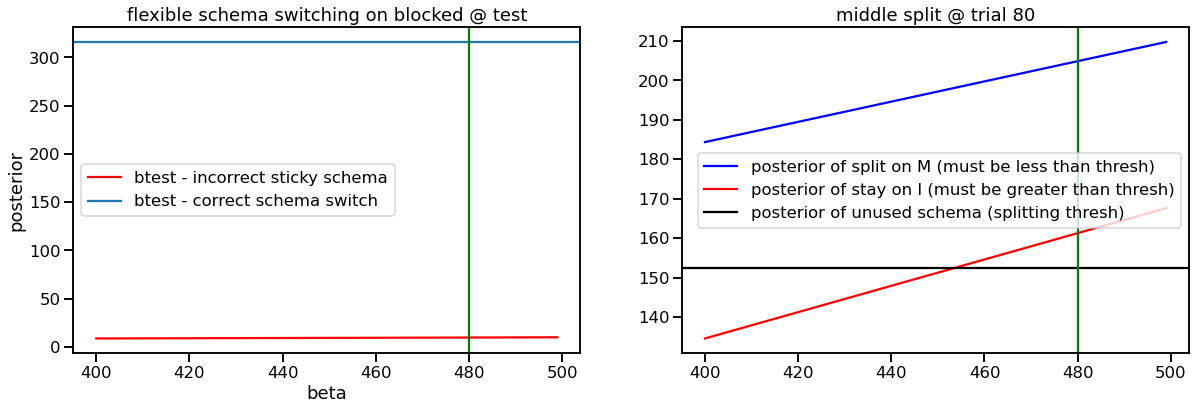

In [5]:
f,axar = plt.subplots(1,2,figsize=(20,6),sharex=True,sharey=False)

## stay interleaved early
l = 1
a = 305
S = 2
bet = 480
x = np.arange(400,500)

## blocked test
# posterior of incorrect sticky schema on first test trial of blocked
A = lambda b: (l/((S*l)+80))*(320+b)
# posterior of correct schema on first test trial of blocked
B = ((l+80)/((S*l)+80))*320

## plt
ax =axar[0]
ax.plot(x,A(x),c='r',label ='btest - incorrect sticky schema')
ax.axhline(B, label ='btest - correct schema switch')
ax.axvline(bet,c='g')
ax.legend()
ax.set_title('flexible schema switching on blocked @ test')
ax.set_xlabel('beta')
ax.set_ylabel('posterior')

## middle splits at trial 80
# stay on second trial of interleaved
stI = lambda b: (l/(S*l+1))*(4+b) 
# split on trial 80 of middle
spM = lambda b: ((l+20)/(S*l+80))*(320+b) 

## plt
ax=axar[1]
ax.set_title('middle split @ trial 80')
ax.plot(x,spM(x),c='b',label='posterior of split on M (must be less than thresh)')
ax.plot(x,stI(x),c='r',label='posterior of stay on I (must be greater than thresh)')
ax.axhline(a/2,c='k',label='posterior of unused schema (splitting thresh)')
ax.axvline(bet,c='g')
ax.legend()

plt.savefig('figures/posterior-vs-beta_middleCI-and-blockedtest')


In [6]:
## default params
taskargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':a,
    'stickiness_wi':bet+200,
    'stickiness_bt':bet, # 100
    'sparsity':l,
    'pvar': 0,
    'lrate':1,
    'lratep':1,
    'decay_rate':1,
} 
semargs = {
  'beta2':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':taskargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_305.000-stickiness_wi_680.000-stickiness_bt_480.000-sparsity_1.000-pvar_0.000-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000'

### main

In [7]:
ns = 1
L = []
condL = ['blocked','interleaved',
         'early','middle','late'
        ]
exp_batch_data = run_batch_exp_curr(ns,args,condL) # [curr,seeds,{data}]


In [8]:
## accuracy
batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
mean_acc = batch_acc.mean(1)
test_acc = mean_acc[:,-40:].mean(1) # curr  
test_acc

array([0.96368027, 0.49439133, 0.75292624, 0.64399459, 0.50332349])

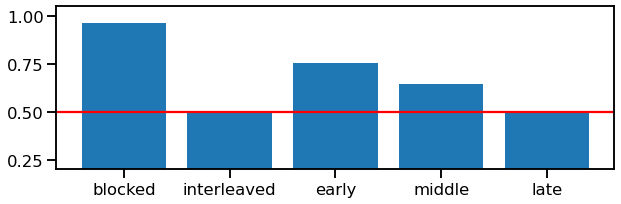

In [9]:
plt.figure(figsize=(10,3))
plt.bar(condL,test_acc)
plt.ylim(0.2,1.05)
plt.axhline(0.5,c='r')

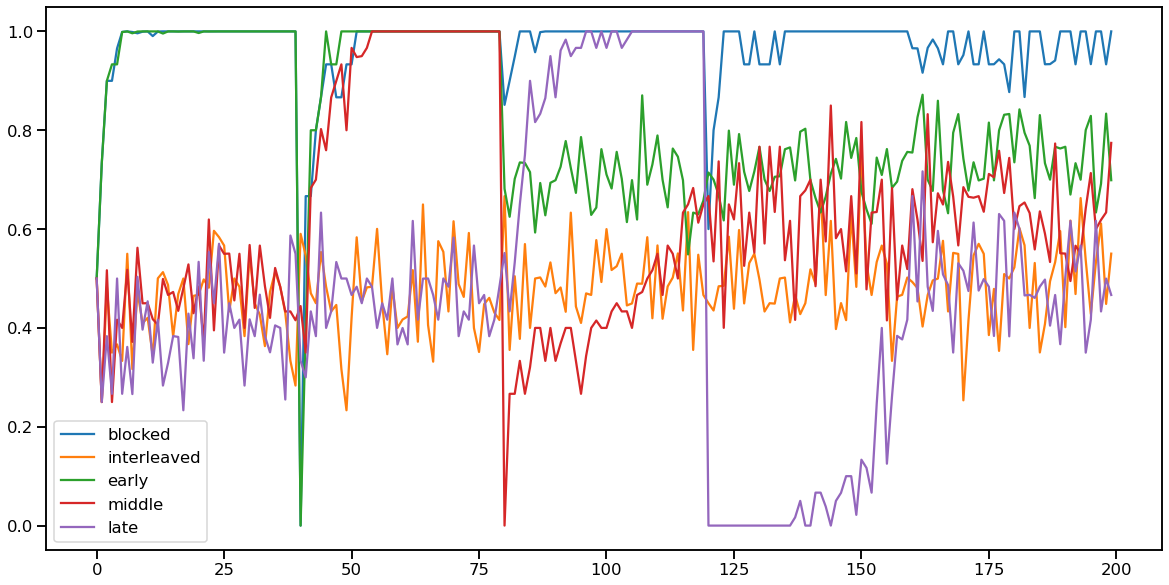

In [10]:
plt.figure(figsize=(20,10))
for idx in range(len(condL)):
  plt.plot(mean_acc[idx],label=condL[idx])
plt.legend()
plt.savefig('figures/noCIonM2-%s.png'%param_str)

<BarContainer object of 5 artists>

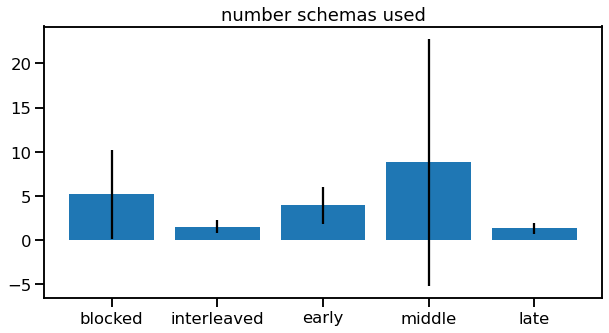

In [11]:
## count number of schemas used
def count_num_schemas(exp_data):
  """ 
  """
  L = []
  for curr_idx in range(5):
    num_schemas_used = [
      len(np.unique(exp_data[curr_idx][i]['zt'][:,:-1].flatten())
         ) for i in range(ns)
    ]
    L.append(num_schemas_used)
  nschemas = np.array(L)
  return nschemas


nschemas = count_num_schemas(exp_batch_data)
M = nschemas.mean(1)
S = nschemas.std(1)
plt.figure(figsize=(10,5))
plt.title('number schemas used')
plt.bar(condL,M,yerr=S)

# model state

In [12]:
curr_idx = 0
seed_idx = 0

In [13]:
priors = unpack_data(exp_batch_data,
        dtype='priors')[curr_idx][seed_idx]
likes = unpack_data(exp_batch_data,
        dtype='likes')[curr_idx][seed_idx]
post = unpack_data(exp_batch_data,
        dtype='post')[curr_idx][seed_idx]


In [14]:
tstep = 0
sch = 0
post[:,tstep,sch]


array([240.5       , 323.33333333, 366.75      , 394.4       ,
       414.16666667, 429.42857143, 441.875     , 452.44444444,
       461.7       , 470.        , 477.58333333, 484.61538462,
       491.21428571, 497.46666667, 503.4375    , 509.17647059,
       514.72222222, 520.10526316, 525.35      , 530.47619048,
       535.5       , 540.43478261, 545.29166667, 550.08      ,
       554.80769231, 559.48148148, 564.10714286, 568.68965517,
       573.23333333, 577.74193548, 582.21875   , 586.66666667,
       591.08823529, 595.48571429, 599.86111111, 604.21621622,
       608.55263158, 612.87179487, 617.175     , 621.46341463,
        15.26190476,   3.83333333,   3.83333333,   3.83333333,
         3.83333333,   3.83333333,   3.83333333,   3.83333333,
         3.83333333,   3.83333333,   3.83333333,   3.83333333,
         3.83333333,   3.83333333,   3.83333333,   3.83333333,
         3.83333333,   3.83333333,   3.83333333,   3.83333333,
         3.83333333,   3.83333333,   3.83333333,   3.83

In [15]:
exp_batch_data[curr_idx][seed_idx]['zt']

array([[ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0., -1.],
       [ 0.,  